In [5]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io, transform
from torchvision.utils import make_grid
import cv2

import albumentations as A
from albumentations.augmentations.crops.transforms import RandomCrop
from albumentations.augmentations.geometric.rotate import Rotate
from albumentations.augmentations.transforms import HorizontalFlip, RGBShift
from albumentations.pytorch import ToTensorV2
%matplotlib inline

In [2]:
root_dir = 'C:\\Users\\91865\\Desktop\\Cat_Dog_data\\train'
os.listdir(root_dir)

['cat', 'dog']

## Custom Dataset

In [6]:
class ImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        super(ImageFolder, self).__init__()
        self.data = []
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = os.listdir(root_dir)

        for index, name in enumerate(self.class_names):
            files = os.listdir(os.path.join(root_dir, name))
            self.data += list(zip(files, [index]*len(files)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_file, label = self.data[index]
        root_and_dir = os.path.join(self.root_dir, self.class_names[label])
        image = np.array(Image.open(os.path.join(root_and_dir, img_file)))

        if self.transform is not None:
            augmentations = self.transform(image=image)
            image = augmentations["image"]

        return image, label

In [7]:
transform = A.Compose(
    [
        A.Resize(width=1920, height=1080),
        A.RandomCrop(width=1280, height=720),
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5),
        ], p=1.0),
        A.Normalize(
            mean=[0, 0, 0],
            std=[1, 1, 1],
            max_pixel_value=255,
        ),
        ToTensorV2(),
    ]
)

In [8]:
dataset = ImageFolder(root_dir=root_dir, transform=transform)

In [10]:
# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

In [11]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([20, 3, 720, 1280])

In [13]:
classes = ['cat','dog']

<ipython-input-14-12bd7e90045f>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


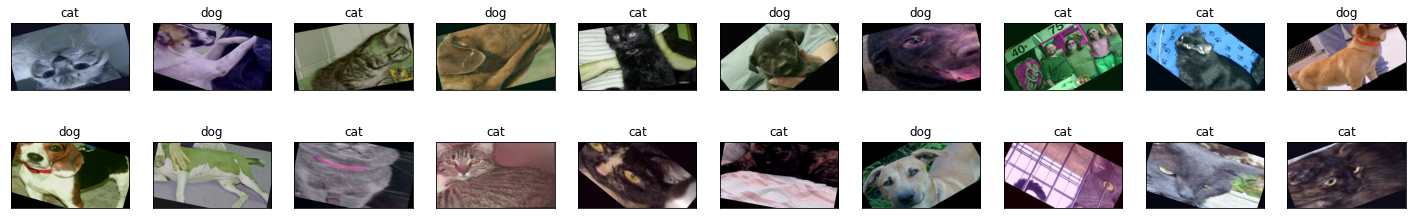

In [14]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])